<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Model-Validation" data-toc-modified-id="Model-Validation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Model Validation</a></span></li><li><span><a href="#Trying-other-metrics-to-judge-the-model." data-toc-modified-id="Trying-other-metrics-to-judge-the-model.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Trying other metrics to judge the model.</a></span></li></ul></li><li><span><a href="#Handling-Class-Imbalance" data-toc-modified-id="Handling-Class-Imbalance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Handling Class Imbalance</a></span><ul class="toc-item"><li><span><a href="#Method-1:-Weighted-Model" data-toc-modified-id="Method-1:-Weighted-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Method 1: Weighted Model</a></span></li><li><span><a href="#Method-2:-Resampling(Oversampling-the-minority-class)" data-toc-modified-id="Method-2:-Resampling(Oversampling-the-minority-class)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Method 2: Resampling(Oversampling the minority class)</a></span></li><li><span><a href="#Method-3:-Resampling(Undersampling-the-majority-class)" data-toc-modified-id="Method-3:-Resampling(Undersampling-the-majority-class)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Method 3: Resampling(Undersampling the majority class)</a></span></li><li><span><a href="#Method-4:-SMOTE" data-toc-modified-id="Method-4:-SMOTE-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Method 4: SMOTE</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
import configuration as config
import utilities as utils
import DataLoader as dl
import ModelGenerator as mg
import Train
import ModelValidation as mv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import math
from imblearn.over_sampling import SMOTE

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
credit_card_data = utils.get_data(config.INPUT_FILE_PATH)

Data loaded from input CSV
Shape of input file:(284807, 31)


In [4]:
no_fraud, fraud = credit_card_data.Class.value_counts()
print(f'No Fraud {no_fraud}')
print(f'Fraud {fraud}')
print(f'Fraud proportion {round(utils.percentage(fraud, no_fraud + fraud), 2)}%')

No Fraud 284315
Fraud 492
Fraud proportion 0.17%


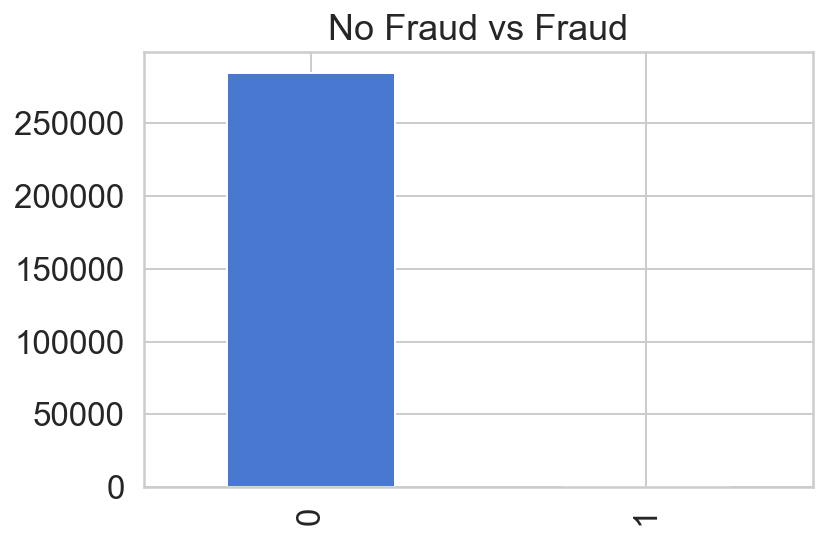

In [5]:
utils.plot_class_balance(credit_card_data, 'Class', title="No Fraud vs Fraud");

In [6]:
data = dl.DataGenerator(credit_card_data, split=0.05)

## Baseline Model

In [7]:
model = mg.build_model(data.X_train)

In [8]:
history = Train.Trainer(model, data).history

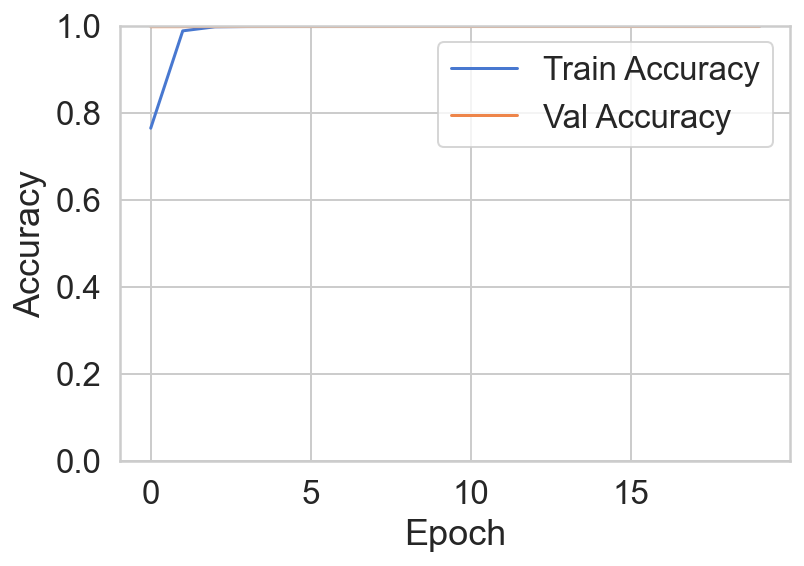

In [9]:
mv.plot_accuracy(history)

In [10]:
model.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE)

14241/14241 [==============================] - 0s 2us/sample - loss: 0.0111 - accuracy: 0.9985


[0.011096182412045234, 0.9985254]

In [11]:
def awesome_model_predict(features):
  return np.full((features.shape[0], ), 0)

In [12]:
y_pred = awesome_model_predict(data.X_test)

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, data.y_test)

0.9985253844533389

### Model Validation



In [14]:
model_pred = model.predict(data.X_test, batch_size=config.BATCH_SIZE)

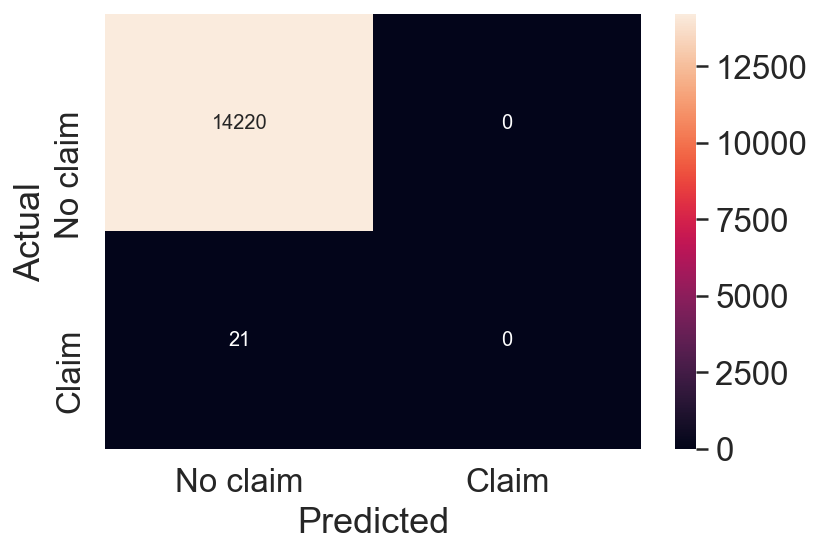

In [15]:
mv.plot_cm(data.y_test, model_pred)

### Trying other metrics to judge the model.

In [16]:
model_metric = mg.build_model(data.X_train, metrics=config.METRICS)

In [17]:
history_metric = Train.Trainer(model_metric, data).history

In [18]:
evaluation_results = model_metric.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_metric.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_metric, evaluation_results, y_pred, data.y_test)

loss :  0.011048827866142941
tp :  0.0
fp :  0.0
tn :  14220.0
fn :  21.0
accuracy :  0.9985254
precision :  0.0
recall :  0.0
auc :  0.49996483
f1 score: 0.0


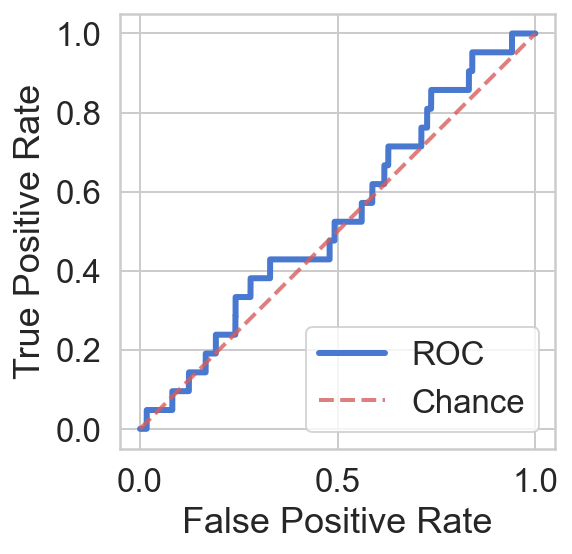

In [19]:
mv.plot_roc(data.y_test, model_pred)

Clearly base model doesn't do justice to the problem. Even a model predicting all the records as 'No Fraud' will give higher accuracy. This can be seen in precision, recall and F1 score


## Handling Class Imbalance

### Method 1: Weighted Model

In [20]:
no_fraud_count, fraud_count = np.bincount(credit_card_data[config.LABEL_COLUMN])
total_count = len(credit_card_data[config.LABEL_COLUMN])

In [21]:
weight_no_fraud = (1 / no_fraud_count) * (total_count) / 2.0
weight_fraud = (1 / fraud_count) * (total_count) / 2.0

class_weights = {0: weight_no_fraud, 1: weight_fraud}

In [22]:
model_weights = mg.build_model(data.X_train, metrics=config.METRICS)

In [23]:
history_wieghts = Train.Trainer(model_weights,data, class_weights, 1)

In [24]:
model_pred = model_weights.predict(data.X_test, batch_size=config.BATCH_SIZE)

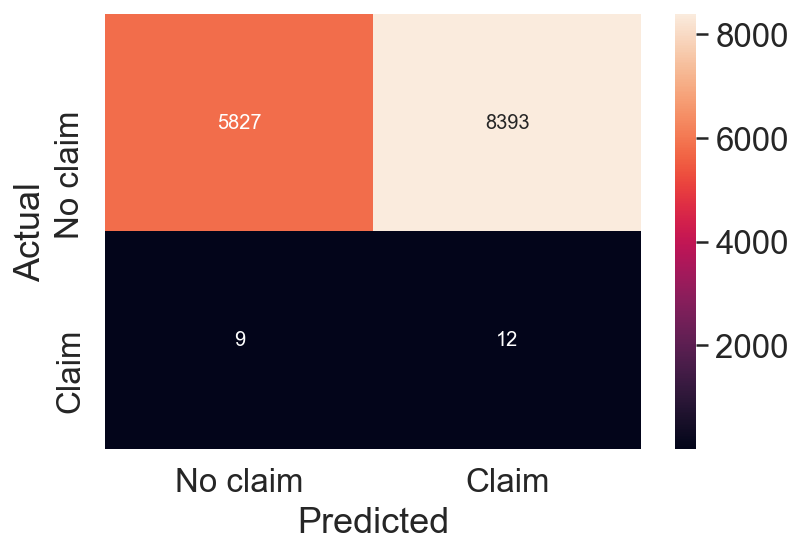

In [25]:
mv.plot_cm(data.y_test, model_pred)

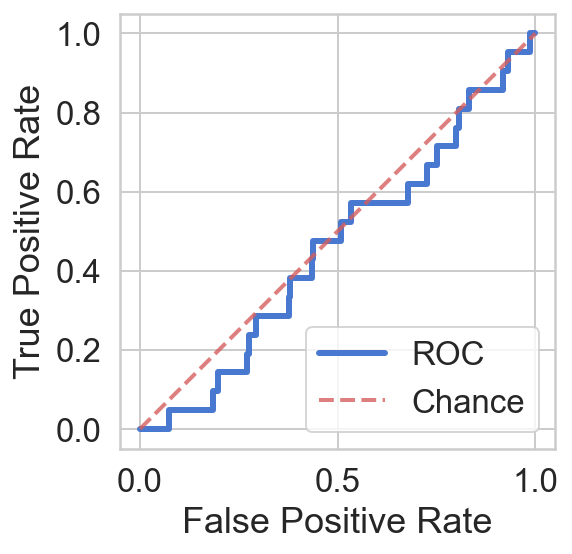

In [26]:
mv.plot_roc(data.y_test, model_pred)

In [27]:
evaluation_results = model_weights.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_weights.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_weights, evaluation_results, y_pred, data.y_test)

loss :  0.7248985496400054
tp :  12.0
fp :  8393.0
tn :  5827.0
fn :  9.0
accuracy :  0.41001335
precision :  0.0014277216
recall :  0.5714286
auc :  0.46568215
f1 score: 0.0028483266081177306


### Method 2: Resampling(Oversampling the minority class)

In [28]:
X = pd.concat([data.X_train, data.y_train], axis=1)

no_fraud = X[X.Class == 0]
fraud = X[X.Class == 1]

In [29]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [30]:
from sklearn.utils import resample

fraud_upsampled = resample(fraud,
                          replace=True, 
                          n_samples=len(no_fraud),
                          random_state=config.RANDOM_SEED)

In [31]:
upsampled = pd.concat([no_fraud, fraud_upsampled])

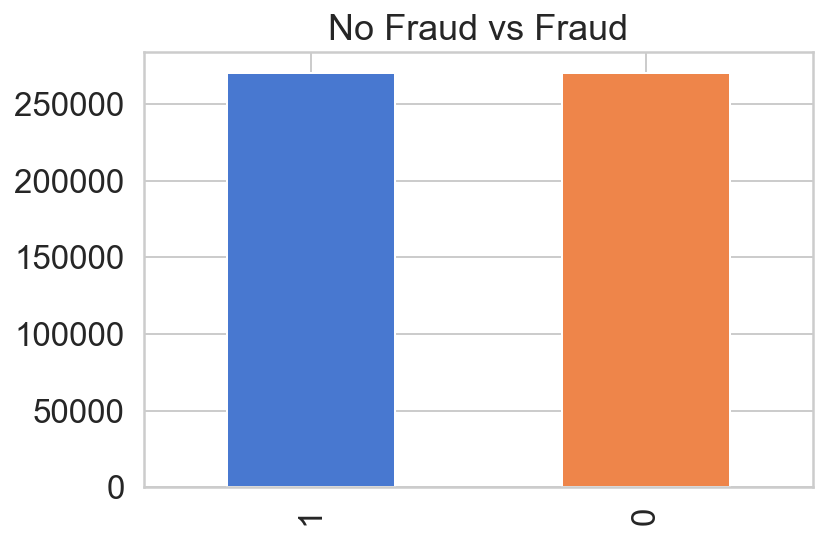

In [32]:
upsampled.Class.value_counts().plot(kind="bar", title="No Fraud vs Fraud");

In [33]:
model_oversampling = mg.build_model(upsampled.drop([config.LABEL_COLUMN], axis = 1), metrics=config.METRICS)

In [34]:
history_oversampling = Train.Trainer(model_oversampling, data).history

In [35]:
model_pred = model_oversampling.predict(data.X_test, batch_size=config.BATCH_SIZE)

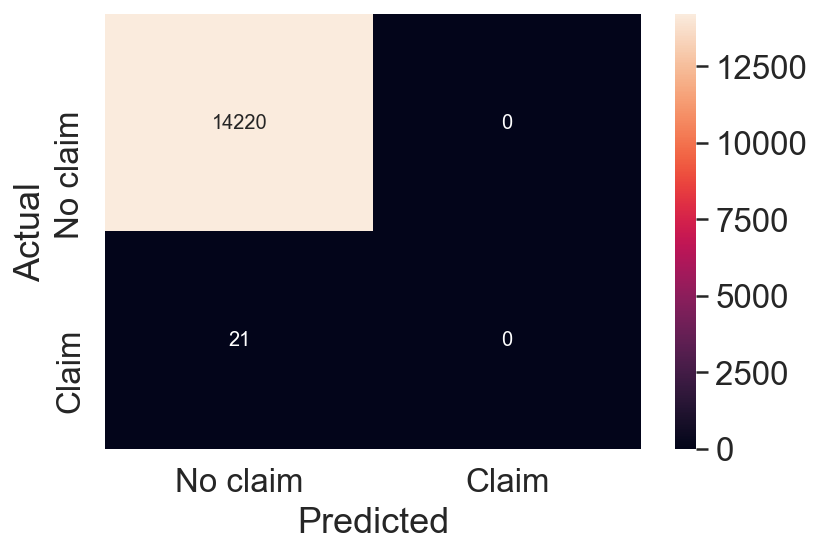

In [36]:
mv.plot_cm(data.y_test, model_pred)

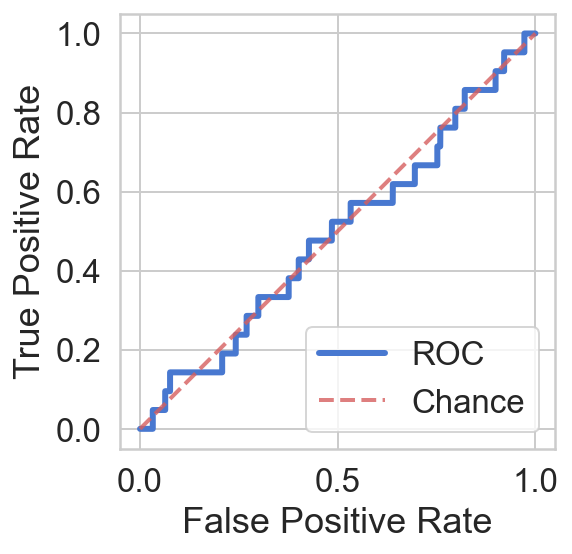

In [37]:
mv.plot_roc(data.y_test, model_pred)

In [38]:
evaluation_results = model_oversampling.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_oversampling.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_oversampling, evaluation_results, y_pred, data.y_test)

loss :  0.011131953512538886
tp :  0.0
fp :  0.0
tn :  14220.0
fn :  21.0
accuracy :  0.9985254
precision :  0.0
recall :  0.0
auc :  0.49996483
f1 score: 0.0


### Method 3: Resampling(Undersampling the majority class)

In [39]:
no_fraud_downsampled = resample(no_fraud,
                                replace = False,
                                n_samples = len(fraud),
                                random_state = config.RANDOM_SEED)

In [40]:
downsampled = pd.concat([no_fraud_downsampled, fraud])

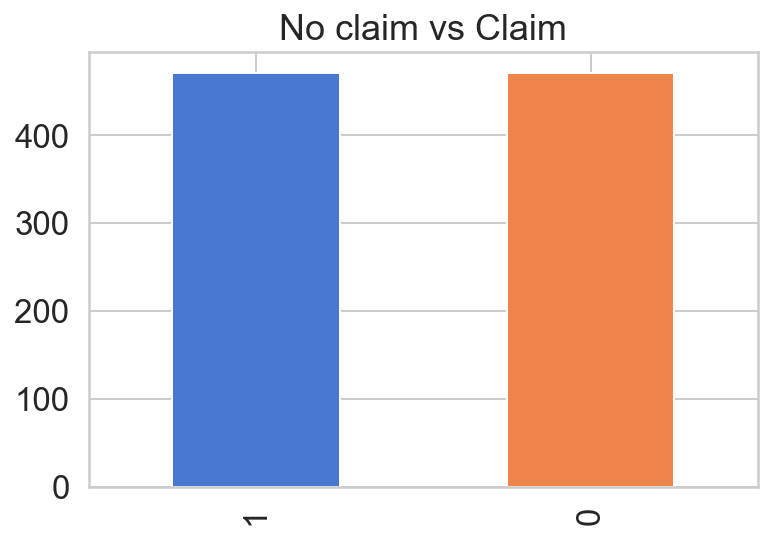

In [41]:
downsampled[config.LABEL_COLUMN].value_counts().plot(kind="bar", title="No claim vs Claim");

In [42]:
model_undersampling = mg.build_model(downsampled.drop([config.LABEL_COLUMN], axis = 1), metrics=config.METRICS)

In [43]:
history_oversampling = Train.Trainer(model_undersampling, data).history

In [44]:
model_pred = model_undersampling.predict(data.X_test, batch_size=config.BATCH_SIZE)

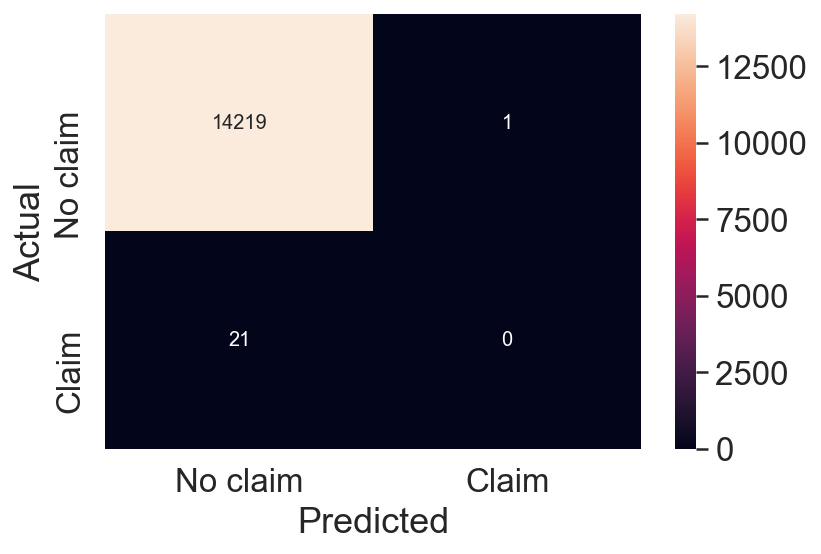

In [45]:
mv.plot_cm(data.y_test, model_pred)

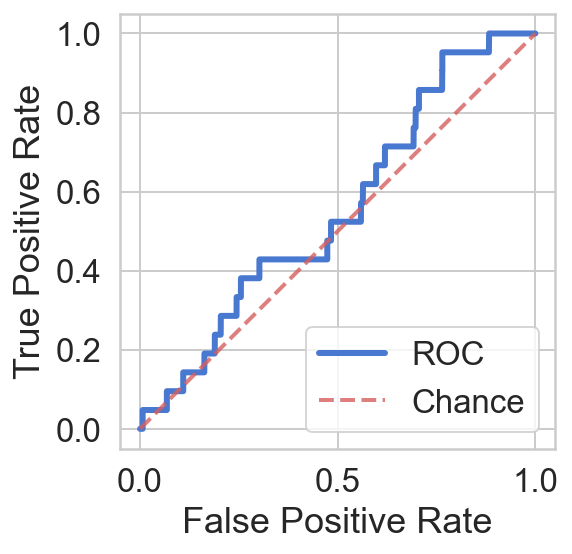

In [46]:
mv.plot_roc(data.y_test, model_pred)

In [47]:
evaluation_results = model_undersampling.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_undersampling.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_undersampling, evaluation_results, y_pred, data.y_test)

loss :  0.011381775718481845
tp :  0.0
fp :  1.0
tn :  14219.0
fn :  21.0
accuracy :  0.99845517
precision :  0.0
recall :  0.0
auc :  0.49996483
f1 score: 0.0


### Method 4: SMOTE

In [48]:
sm = SMOTE(random_state= config.RANDOM_SEED, sampling_strategy=1.0)

In [49]:
Y_train = X[config.LABEL_COLUMN]
X_train = X.drop(config.LABEL_COLUMN, axis=1)

In [50]:
X_train, y_train = sm.fit_sample(X_train, Y_train)

In [51]:
data.X_train = X_train
data.y_train = y_train

In [52]:
model_smote = mg.build_model(data.X_train, metrics=config.METRICS)

In [53]:
history_smote = Train.Trainer(model_smote, data).history

In [54]:
model_pred = model_smote.predict(data.X_test, batch_size=config.BATCH_SIZE)

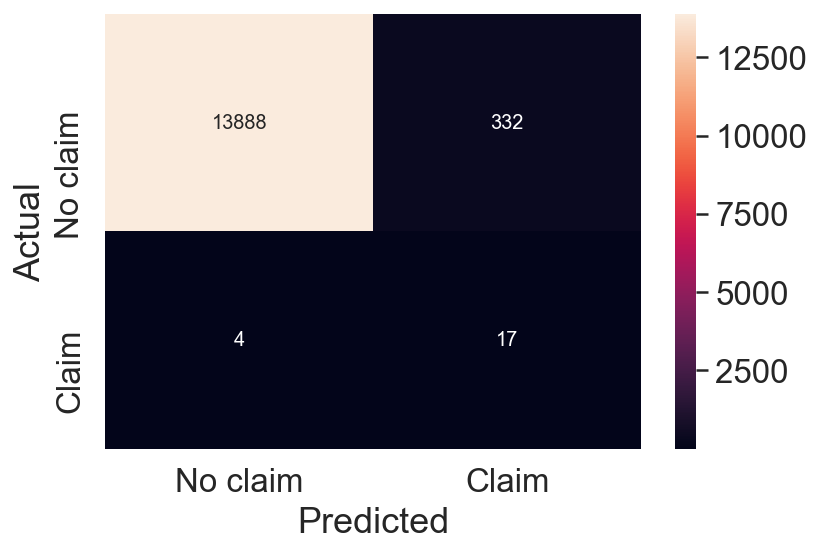

In [55]:
mv.plot_cm(data.y_test, model_pred)

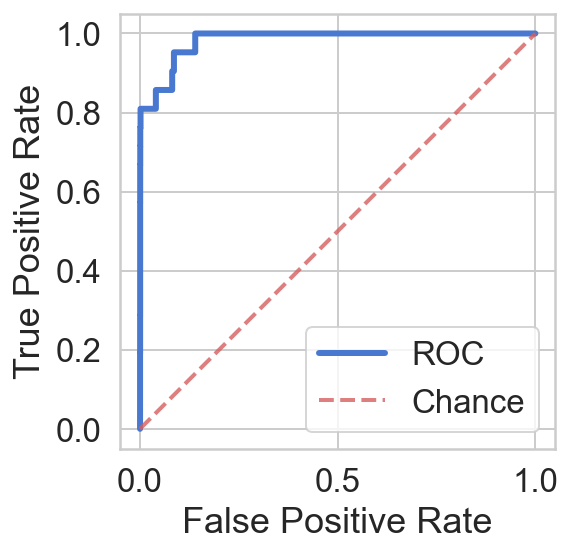

In [56]:
mv.plot_roc(data.y_test, model_pred)

In [57]:
evaluation_results = model_smote.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_smote.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_smote, evaluation_results, y_pred, data.y_test)

loss :  0.13831860883547661
tp :  17.0
fp :  332.0
tn :  13888.0
fn :  4.0
accuracy :  0.97640616
precision :  0.048710603
recall :  0.8095238
auc :  0.9831424
f1 score: 0.09189189189189188


## Conclusion

Clearly for this dataset, SMOTE(Synthetic Minority Oversampling Technique) emerges as a winner when it comes to handling class balance. 
This can be seen through precision, recall, f1 score and auc-roc values.<br> We can always try out more ratios in SMOTE or experiment with the number of nearest neighbours to get higher values for these metrics.
Generally assigning class weights and SMOTE are used more often than the other techniques.